In [8]:
# Importar librerías
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

# Evaluación
from sklearn.metrics import silhouette_score

# Reducción de dimensionalidad / visualización
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [22]:
df = pd.read_csv('MusicInfo.csv')
df.head()


,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


In [23]:
#verificar si hay valores nulos
print(df.isnull().sum())

track_id                   0
name                       0
artist                     0
spotify_preview_url        0
spotify_id                 0
tags                    1127
genre                  28335
year                       0
duration_ms                0
danceability               0
energy                     0
key                        0
loudness                   0
mode                       0
speechiness                0
acousticness               0
instrumentalness           0
liveness                   0
valence                    0
tempo                      0
time_signature             0
dtype: int64


In [24]:
# Eliminar columna que no usaremos
df_clust = df.drop(columns=['tags'])

# Quedarnos solo con los ejemplos que si tienen genero
df_clust = df_clust.dropna(subset=['genre'])

print(f"Ejemplos para clustering: {len(df_clust)} (de {len(df)})")



Ejemplos para clustering: 22348 (de 50683)


In [25]:
# Selección de columnas numericas relevantes
feature_cols = [
    'duration_ms',
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo'
]

# Extraemos solo esas columnas
df_features = df_clust[feature_cols]

# tipo de datos
print("Shape de features:", df_features.shape)
print(df_features.dtypes)


Shape de features: (22348, 10)
duration_ms           int64
danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object


In [27]:
print(df_features.head())

    duration_ms  danceability  energy  loudness  speechiness  acousticness  \
2        218920         0.508   0.826    -5.783       0.0400      0.000175   
4        238640         0.515   0.430    -9.935       0.0369      0.010200   
8        311014         0.566   0.429    -7.826       0.0242      0.715000   
10       265506         0.554   0.490    -8.046       0.0457      0.016800   
12       223106         0.809   0.720    -7.776       0.1360      0.033700   

    instrumentalness  liveness  valence    tempo  
2           0.000459    0.0878    0.543  120.012  
4           0.000141    0.1290    0.104   91.841  
8           0.000014    0.1200    0.173  146.365  
10          0.000534    0.1360    0.513   84.275  
12          0.001410    0.8260    0.832  138.556  


In [28]:
# Crear el scaler
scaler = StandardScaler()

# Ajustar y transformar
X_scaled = scaler.fit_transform(df_features)
print("Shape de X_scaled:", X_scaled.shape)

Shape de X_scaled: (22348, 10)


Grafico k-distancia para elegir eps

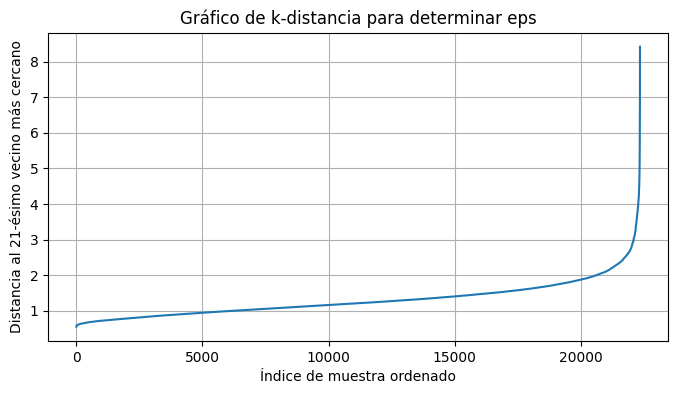

In [29]:
# Define el valor de min_samples que usarás en DBSCAN
min_samples = 21  # D + 1

# Calcula distancias al k-ésimo vecino más cercano
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)

# Ordena las distancias del vecino k-ésimo y grafícalas
k_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.xlabel('Índice de muestra ordenado')
plt.ylabel(f'Distancia al {min_samples}-ésimo vecino más cercano')
plt.title('Gráfico de k-distancia para determinar eps')
plt.grid(True)
plt.show()


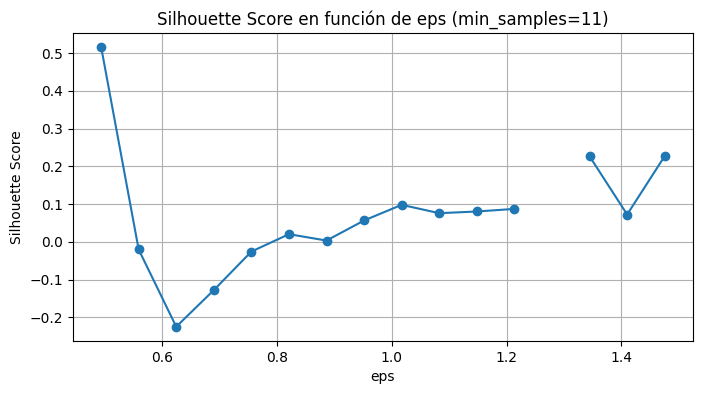

In [30]:

# Rango de valores de eps a probar
eps_values = np.linspace(0.1, 2.0, 30)
sil_scores = []

# Iterar sobre cada eps
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=11).fit(X_scaled)
    labels = db.labels_
    mask = labels != -1
    if len(np.unique(labels[mask])) > 1:
        score = silhouette_score(X_scaled[mask], labels[mask], sample_size=5000, random_state=42)
    else:
        score = np.nan
    sil_scores.append(score)

# Graficar Silhouette vs eps
plt.figure(figsize=(8, 4))
plt.plot(eps_values, sil_scores, marker='o')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score en función de eps (min_samples=11)')
plt.grid(True)
plt.show()


In [91]:
eps = 1.0037
min_samples = 11

db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
labels = db.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_ratio = np.mean(labels == -1)
print(f"Clusters detectados (sin ruido): {n_clusters}")
print(f"Proporción de ruido: {noise_ratio:.2%}")

mask = labels != -1
if n_clusters > 1:
    sil = silhouette_score(X_scaled[mask], labels[mask])
    print(f"Silhouette score: {sil:.3f}")
else:
    print("No hay suficientes clusters para Silhouette.")

    df_eval = df_clust.copy()
df_eval['cluster'] = labels

purity_per_cluster = df_eval[df_eval.cluster != -1].groupby('cluster')['genre'] \
    .apply(lambda x: x.value_counts().iloc[0] / x.size)
overall_purity = (purity_per_cluster * df_eval[df_eval.cluster != -1].groupby('cluster').size()).sum() \
                 / df_eval[df_eval.cluster != -1].shape[0]
print(f"Pureza global de clusters: {overall_purity:.2%}")

Clusters detectados (sin ruido): 5
Proporción de ruido: 42.55%
Silhouette score: 0.104
Pureza global de clusters: 50.48%


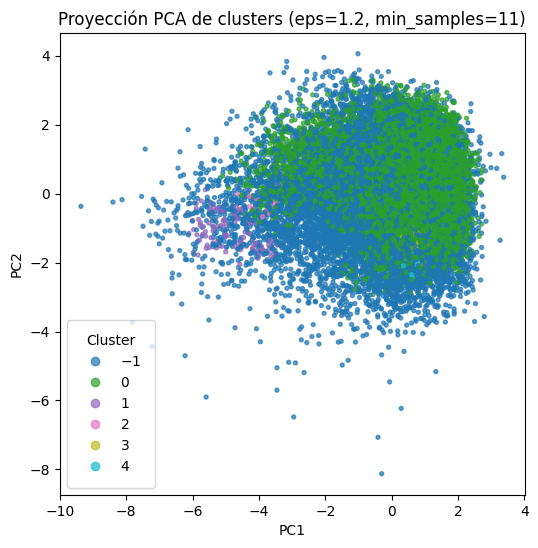

In [92]:
# Proyectar a 2 componentes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=labels, cmap='tab10', s=8, alpha=0.7
)
plt.legend(
    *scatter.legend_elements(), title="Cluster",
    loc='best', borderpad=1
)
plt.title("Proyección PCA de clusters (eps=1.2, min_samples=11)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


In [93]:


# 7.1) Añadir etiqueta de cluster a tu DataFrame de features
df_profile = df_clust[feature_cols].copy()
df_profile['cluster'] = labels

# 7.2) Media de cada feature por cluster (excluyendo ruido = -1)
cluster_means = df_profile[df_profile.cluster != -1].groupby('cluster').mean()
print("Perfil (media) de cada cluster:\n", cluster_means)




Perfil (media) de cada cluster:
            duration_ms  danceability    energy   loudness  speechiness  \
cluster                                                                  
0        237349.121492      0.505317  0.753367  -6.671024     0.059373   
1        216113.317757      0.195650  0.172899 -18.080327     0.039040   
2        244169.166667      0.491556  0.251833 -14.587667     0.033967   
3        368667.529412      0.567000  0.914176  -6.352588     0.072712   
4        318139.250000      0.493417  0.884417  -6.089167     0.060650   

         acousticness  instrumentalness  liveness   valence       tempo  
cluster                                                                  
0            0.128541          0.097816  0.171007  0.463726  124.853426  
1            0.916953          0.884916  0.116105  0.074030   86.659598  
2            0.873167          0.851778  0.106344  0.133222  109.884278  
3            0.015593          0.815353  0.114035  0.375412  170.281176  
4   

In [94]:
# 7.3) Género mayoritario por cluster
genre_mode = df_eval[df_eval.cluster != -1].groupby('cluster')['genre'] \
               .agg(lambda x: x.value_counts().idxmax())
print("\nGénero mayoritario en cada cluster:\n", genre_mode)


Género mayoritario en cada cluster:
 cluster
0          Rock
1          Rock
2          Rock
3    Electronic
4    Electronic
Name: genre, dtype: object


In [95]:
from sklearn.neighbors import KNeighborsClassifier

# 8.1) Tomar sólo los core-samples de DBSCAN
core_idx = db.core_sample_indices_
X_core = X_scaled[core_idx]
y_core = labels[core_idx]

# 8.2) Entrenar KNN
knn = KNeighborsClassifier(n_neighbors= min_samples*2)
knn.fit(X_core, y_core)

# 8.3) Ejemplo de predicción con nuevos vectores
X_new = [[0.5, 0.7, -1.2, 0.3, 0.1, -0.5, 1.0, 0.2, 0.4, 0.0]]  # en escala
pred_cluster = knn.predict(X_new)
print("Nuevo punto asignado al cluster:", pred_cluster[0])


Nuevo punto asignado al cluster: 0


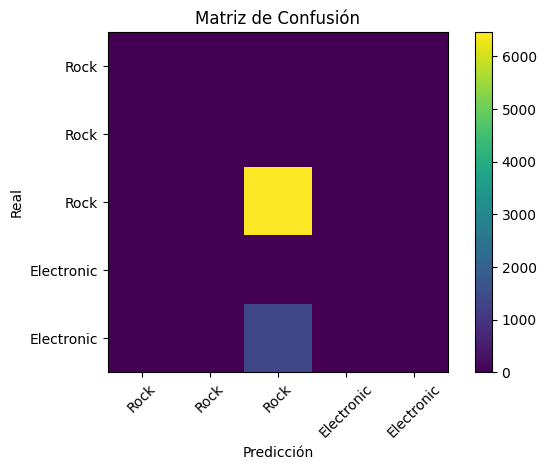

In [ ]:
#  Cálculo de matriz de confusión
cm = confusion_matrix(
    df_eval['genre'],
    df_eval['pred_genre'],
    labels=list(cluster_to_genre.values())
)
cm_df = pd.DataFrame(cm, index=list(cluster_to_genre.values()), columns=list(cluster_to_genre.values()))

# 6) Heatmap de la matriz de confusión
plt.figure()
plt.imshow(cm_df.values, interpolation='nearest')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(range(len(cm_df.columns)), cm_df.columns, rotation=45)
plt.yticks(range(len(cm_df.index)), cm_df.index)
plt.colorbar()
plt.tight_layout()
plt.show()